<a href="https://colab.research.google.com/github/bella0826/flowers/blob/main/%E8%98%AD%E8%8A%B1_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

import matplotlib.pyplot as plt


image_path = "/content/drive/MyDrive/data/training/"
label_path = "/content/drive/MyDrive/data/training/label.csv"



In [ ]:
def load_data():
  x_train = []
  y_train = []
  label_df = pd.read_csv(label_path, index_col = "filename")
  for p in os.listdir(image_path):
    if p != "label.csv":
      path = image_path + p
      img = cv2.imread(path)
      image = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA)
      x_train.append(np.array(image))
      y_train.append(label_df.loc[str(p),"category"])
      #print(p,label_df.loc[str(p),"category"])
  return x_train,y_train

In [ ]:
def build_model():
  model = Sequential()

  model.add(ResNet50(include_top=False, weights='imagenet', pooling = 'avg', classes=219, input_shape=(200,200,3)))

  #model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(219, activation='softmax'))

  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())

  return model

In [ ]:
def show_train_history(train_history,train,validation): #validation
  
  if train == 'accuracy':
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history(acc)')
    plt.ylabel('train')
    plt.xlabel('epoch')
  else:
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history(loss)')
    plt.ylabel('train')
    plt.xlabel('epoch')

  plt.legend(['train','validation'],loc='upper left')
  plt.show()

In [ ]:
if __name__ == '__main__':
  x_train, y_train = load_data()
  x_train = np.array(x_train).astype('float32')
  y_train = np.array(y_train).astype('float32')
  x_train = x_train/255.0
  y_train = to_categorical(y_train,219)
  
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

  datagen = ImageDataGenerator(
      vertical_flip=True,
      rotation_range = 10,
      horizontal_flip = True,
      zoom_range = 0.1
  )
  datagen.fit(x_train)

  model = build_model()


  #history = model.fit(x_train, y_train, batch_size = 32, epochs = 20, verbose = 1)
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32), validation_data = (x_test,y_test), epochs = 50 ,verbose = 1)

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 219)               112347    
                                                                 
Total params: 24,749,147
Trainable params: 24,696,027
Non-trainable params: 53,120
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
55/55 [==============================] - 38s 402ms/step - loss: 5.4167 - accuracy: 0.0120 - val_loss: 5.7113 - val_accuracy: 0.0046
Epoch 2/50
55/55 [==============================] - 20s 358ms/step - loss: 4.7958 - accuracy: 0.0993 - val_loss: 7.6623 - val_accuracy: 0.0046
Epoch 3/50
55/55 [==============================] - 19s 351ms/step - loss: 3.9032 - accuracy: 0.2825 - val_loss: 8.3547 - val_accuracy: 0.0068
Epoch 4/50
55/55 [==============================] - 20s 352ms/step - loss: 2.8997 - accuracy: 0.4749 - val_loss: 9.7230 - val_accuracy: 0.0046
Epoch 5/50
55/55 [==============================] - 20s 356ms/step - loss: 2.0964 - accuracy: 0.6261 - val_loss: 10.3036 - val_accuracy: 0.0046
Epoch 6/50
55/55 [==============================] - 20s 356ms/step - loss: 1.4444 - accuracy: 0.7432 - val_loss: 10.2837 - val_accuracy: 0.0046
Epoch 7/50
55/55 [==============================] - 20s 356ms/step - loss: 1.0357 - accuracy: 0.8231 - val_loss: 7.9137 - val_accuracy: 0.00

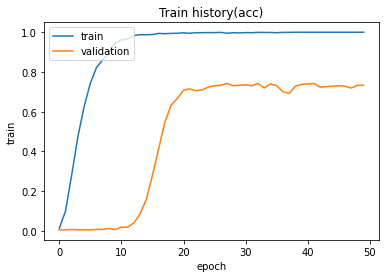

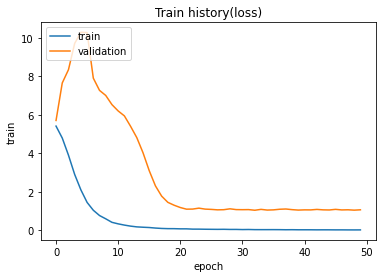

In [ ]:
show_train_history(history,"accuracy","val_accuracy")
show_train_history(history,"loss","val_loss")

In [ ]:
scores=model.evaluate(x_test,y_test)
print()
print('accuracy:',scores[1])

14/14 [==============================] - 1s 90ms/step - loss: 1.0592 - accuracy: 0.7329

accuracy: 0.732876718044281


In [ ]:
def plot_images_labels(images,labels,prediction,idx,num=50):
    fig=plt.gcf()
    fig.set_size_inches(12,14)
    if num>25:
        num=15
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(np.reshape(images[idx],(200,200,3)), cmap='binary')
        title="label=" +str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title+=",predict="+str(np.argmax(prediction[idx]))
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx=idx+1
    plt.show()

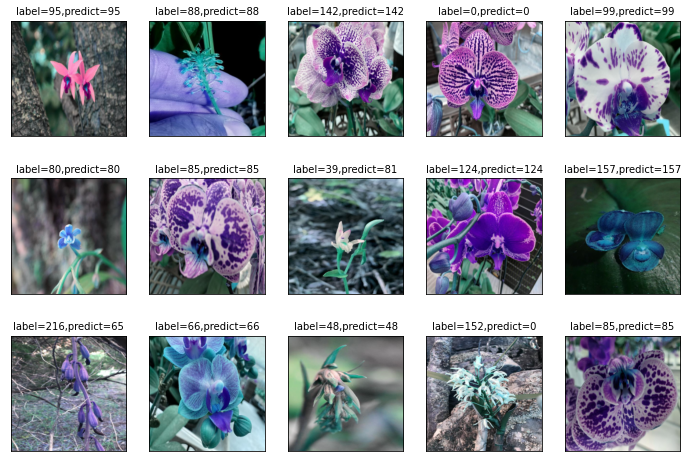

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype('int32')

#print the result of predictions from test data(index = 200)
plot_images_labels(x_test,y_test,predictions,idx=10)  